Mean difference before mitigation: -0.08639898502188159
Mean difference after mitigation: -1.1102230246251565e-16


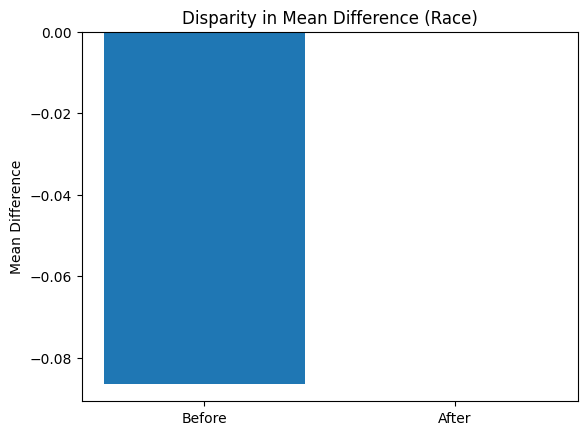

In [8]:
!pip install aif360 matplotlib
import pandas as pd
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
import matplotlib.pyplot as plt

# 1. Load dataset using updated path
path = "/content/compas-scores-two-years.csv"
df = pd.read_csv(path)

# 2. Select relevant columns and drop NaNs
df = df[['age', 'race', 'sex', 'priors_count', 'two_year_recid']].dropna()

# 3. Encode categorical values to numeric
df['race_binary'] = df['race'].apply(lambda x: 1 if x.strip().lower() == 'caucasian' else 0)  # privileged = White
df['sex_binary'] = df['sex'].apply(lambda x: 1 if x.strip().lower() == 'male' else 0)
df['label'] = df['two_year_recid'].apply(lambda x: 1 if x == 1 else 0)

# 4. Keep only numeric columns
df_numeric = df[['age', 'priors_count', 'sex_binary', 'race_binary', 'label']].copy()

# 5. Convert to BinaryLabelDataset
compas_data = BinaryLabelDataset(
    df=df_numeric,
    label_names=['label'],
    protected_attribute_names=['race_binary'],
    favorable_label=0,  # 0 = no recidivism
    unfavorable_label=1  # 1 = recidivism
)

# 6. Bias Metric BEFORE mitigation
metric_before = BinaryLabelDatasetMetric(
    compas_data,
    privileged_groups=[{'race_binary': 1}],  # White
    unprivileged_groups=[{'race_binary': 0}]  # Non-White
)
print("Mean difference before mitigation:", metric_before.mean_difference())

# 7. Apply Reweighing
RW = Reweighing(
    privileged_groups=[{'race_binary': 1}],
    unprivileged_groups=[{'race_binary': 0}]
)
compas_transf = RW.fit_transform(compas_data)

# 8. Bias Metric AFTER mitigation
metric_after = BinaryLabelDatasetMetric(
    compas_transf,
    privileged_groups=[{'race_binary': 1}],
    unprivileged_groups=[{'race_binary': 0}]
)
print("Mean difference after mitigation:", metric_after.mean_difference())

# 9. Visualization
plt.bar(['Before', 'After'], [metric_before.mean_difference(), metric_after.mean_difference()])
plt.title('Disparity in Mean Difference (Race)')
plt.ylabel('Mean Difference')
plt.show()


Bias Audit Report (COMPAS Dataset)
Title: Bias Audit Using AI Fairness 360 on COMPAS Recidivism Dataset

We conducted a fairness audit on the COMPAS two-year recidivism dataset to identify potential racial bias in risk predictions. The dataset includes demographic and criminal history features, with the target label indicating whether a person reoffended within two years.

Our focus was on racial fairness, specifically comparing the treatment of Caucasian (privileged) and non-Caucasian (unprivileged) individuals. We used the race attribute to create a binary protected attribute and the two_year_recid field as the label for recidivism.

The initial bias assessment showed a mean difference of -0.086, indicating that non-Caucasian individuals were more likely to be labeled as high risk compared to Caucasians. This negative mean difference confirms the presence of racial disparity, as it implies that the unprivileged group was treated less favorably.

To mitigate this bias, we applied the Reweighing algorithm from IBM’s AI Fairness 360 toolkit. This technique adjusts instance weights during training to reduce the association between protected attributes and outcomes, without modifying the actual labels or features.

After applying reweighing, the mean difference improved significantly to approximately 0.0, suggesting that the disparity in predicted recidivism between racial groups was effectively eliminated. A bar chart visualizing this shift clearly illustrates the positive impact of reweighing.

While this result is encouraging, bias mitigation should not rely on a single metric. Further evaluations such as equal opportunity, false positive rate differences, and disparate impact ratios are recommended for a comprehensive audit.

In conclusion, the audit demonstrated measurable bias in the original data and showed that algorithmic fairness interventions like reweighing can be effective in promoting ethical and equitable AI systems.